In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from golab import *

# Fit a single concentration-response curve

ymax: 3.030841700866356
EC50: 1.080734112808675e-06
slope: 0.8835225423320361


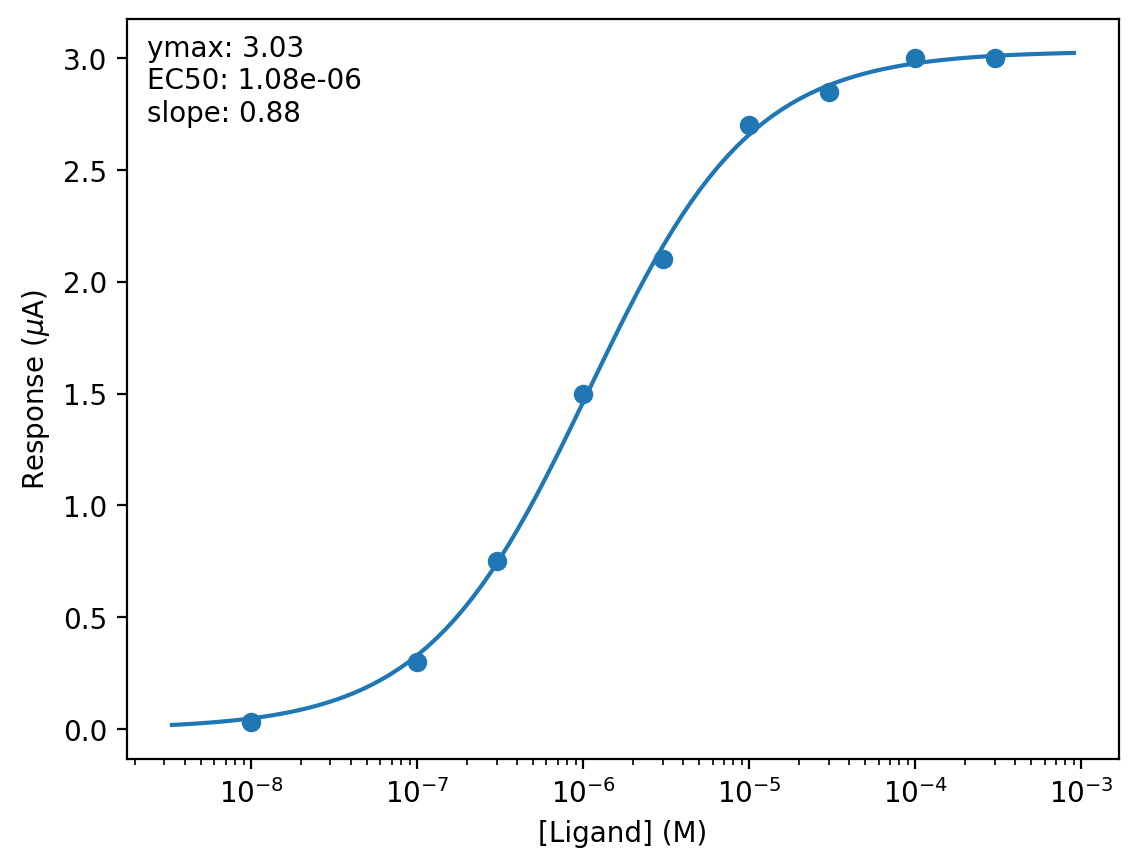

In [2]:
# data (input your data here)
x = np.array([10e-9, 100e-9, 300e-9, 1e-6, 3e-6, 10e-6, 30e-6, 100e-6, 300e-6])
y = np.array([0.03, 0.3, 0.75, 1.5, 2.1, 2.7, 2.85, 3, 3])

# initial guess for parameters (ymax, EC50, Hill slope)
# (order of parameters reflects that in hill_equation)
params = [
    max(y),        # ymax (remove this to constrain ymax=1)
    np.median(x),  # EC50
    1,             # Hill slope
]

# [(lower bounds), (upper bounds)]
bounds = [
    (
        0,       # ymax lower bound (remove this if constraining ymax=1)
        min(x),  # EC50 lower bound
        0,       # Hill slope lower bound
    ),
    (
        np.inf,  # ymax upper bound (remove this if constraining ymax=1)
        max(x),  # EC50 upper bound
        np.inf,  # Hill slope upper bound
    )
]

# optimize fit parameters
params = fit_CRC(x, y, params, bounds)
ymax, EC50, slope = params
print(f'ymax: {ymax}\nEC50: {EC50}\nslope: {slope}')

# plot data with fitted curve
plot_CRC(x, y, params, normalize=False, show_params_text=True)

# axis labels
plt.xlabel('[Ligand] (M)')
plt.ylabel(r'Response ($\mu$A)');

# Plot multiple concentration-response curves (optionally normalized)

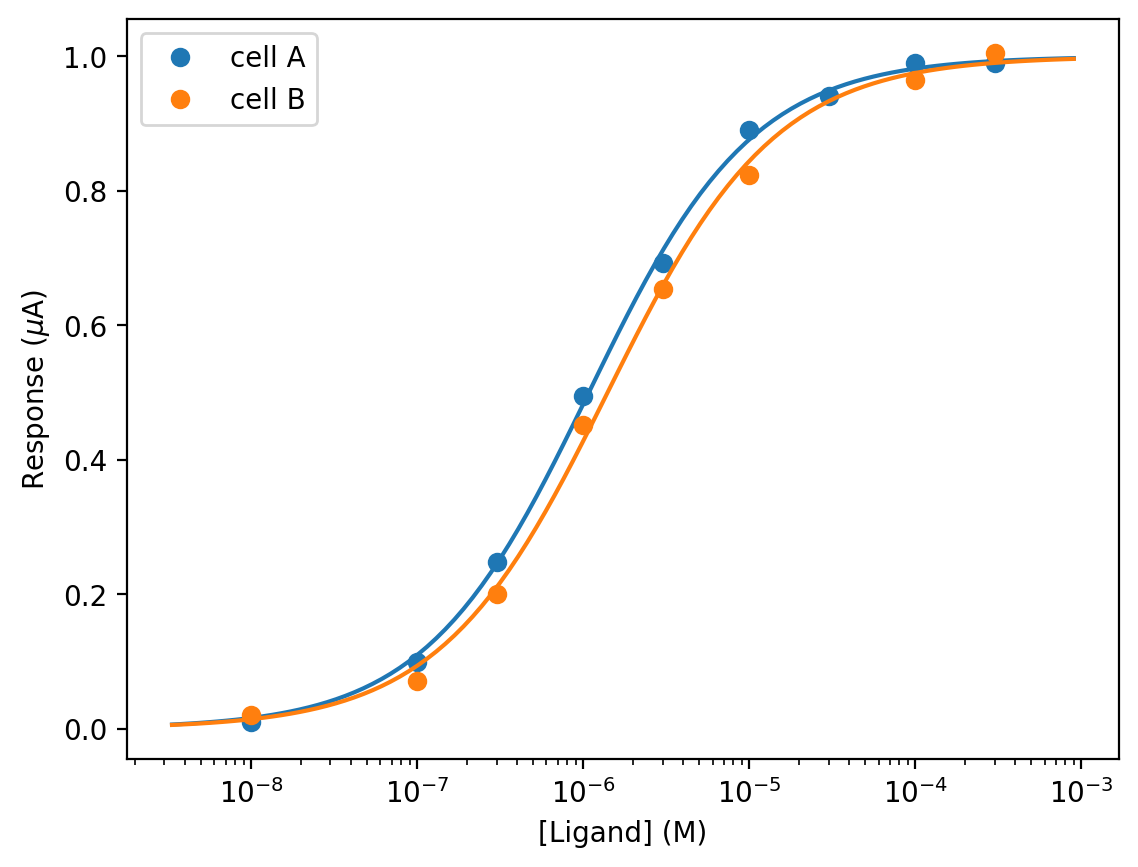

In [3]:
# Each entry in data is for a single concentration-response curve.
# Edit to include your data.
data = [
    {
        'label': 'cell A',
        'marker': 'o',
        'x': np.array([10e-9, 100e-9, 300e-9, 1e-6, 3e-6, 10e-6, 30e-6, 100e-6, 300e-6]),
        'y': np.array([0.03, 0.3, 0.75, 1.5, 2.1, 2.7, 2.85, 3, 3]),
        'ymax': 3.03,
        'EC50': 1.08e-6,
        'slope': 0.88,
    },
    {
        'label': 'cell B',
        'x': np.array([10e-9, 100e-9, 300e-9, 1e-6, 3e-6, 10e-6, 100e-6, 300e-6]),
        'y': np.array([0.04, 0.14, 0.4, 0.9, 1.3, 1.64, 1.92, 2]),
        'ymax': 1.99,
        'EC50': 1.40e-6,
        'slope': 0.86,
    },
]

# plot curves
normalize = True  # normalize curves to ymax?
for cell in data:
    label = cell.get('label', None)
    marker = cell.get('marker', 'o')
    x = cell['x']
    y = cell['y']
    ymax = cell.get('ymax', max(y))
    EC50 = cell.get('EC50', None)
    slope = cell.get('slope', None)
    if (EC50 is not None) and (slope is not None):
        params = (ymax, EC50, slope)
    else:
        params = None

    plot_CRC(x, y, params, normalize=normalize, show_params_text=False, label=label)

# axis labels and legend
plt.xlabel('[Ligand] (M)')
plt.ylabel(r'Response ($\mu$A)')
plt.legend();

# Fit agreggated data across multiple normalized concentration-response curves

EC50: 1.2318588924126172e-06
slope: 0.8716252810064528


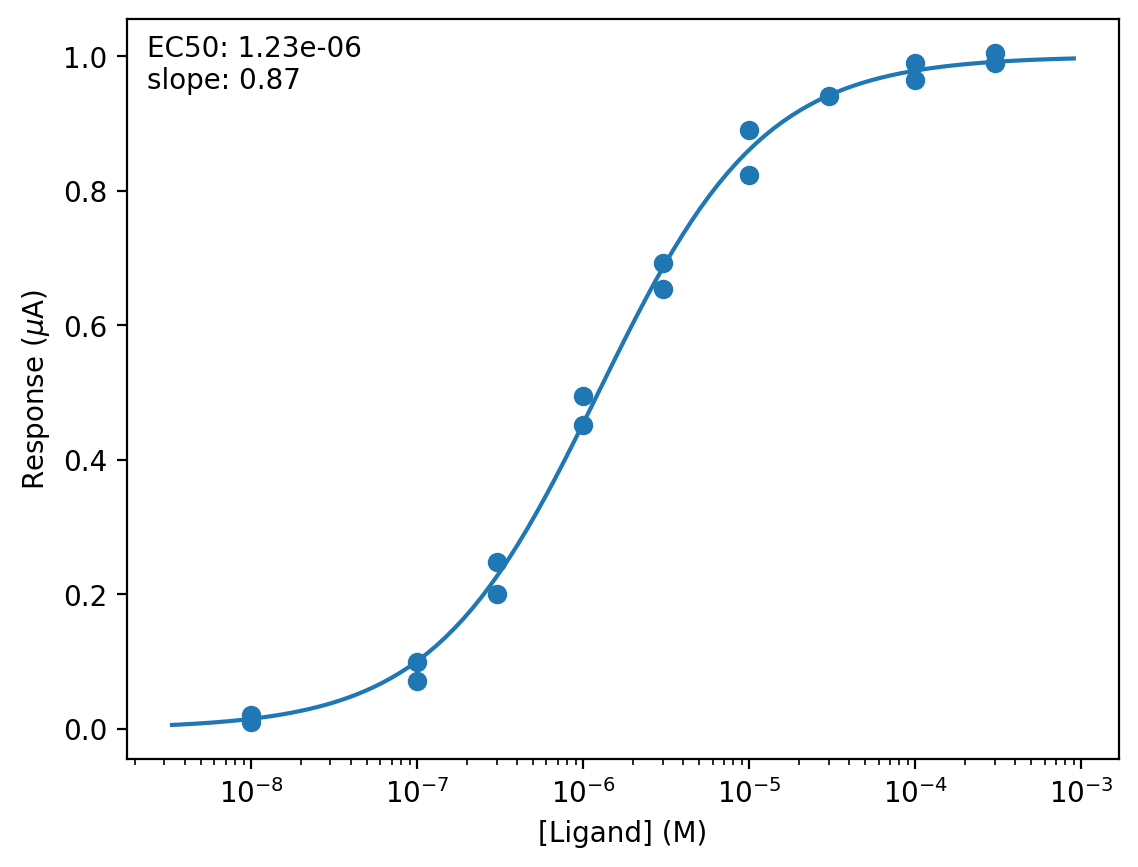

In [4]:
# get aggregated normalized data from `data` variable above
x = np.concatenate([cell['x'] for cell in data])
y = np.concatenate([cell['y'] / cell.get('ymax', max(cell['y'])) for cell in data])

# initial guess for parameters (ymax, EC50, Hill slope)
# (order of parameters reflects that in hill_equation)
params = [
    np.median(x),  # EC50
    1,             # Hill slope
]

# [(lower bounds), (upper bounds)]
bounds = [
    (
        min(x),  # EC50 lower bound
        0,       # Hill slope lower bound
    ),
    (
        max(x),  # EC50 upper bound
        np.inf,  # Hill slope upper bound
    )
]

# optimize fit parameters
params = fit_CRC(x, y, params, bounds)
EC50, slope = params
print(f'EC50: {EC50}\nslope: {slope}')

# plot data with fitted curve
plot_CRC(x, y, params, normalize=False, show_params_text=True)

# axis labels
plt.xlabel('[Ligand] (M)')
plt.ylabel(r'Response ($\mu$A)');